In [1]:
!git clone https://github.com/martha92/babycry.git

fatal: destination path 'babycry' already exists and is not an empty directory.


In [2]:
!rm /content/babycry/Data/Audio_augmentation/data_augment.py

rm: cannot remove '/content/babycry/Data/Audio_augmentation/data_augment.py': No such file or directory


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      592       
                                                                 
 flatten (Flatten)           (None, 254016)            0         
                                                                 
 dense (Dense)               (None, 7)                 1778119   
                                                                 
Total params: 1778711 (6.79 MB)
Trainable params: 1778711 (6.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2000
13/13 [==============================] - 2s 38ms/step - loss: 12.6186 - accuracy: 0.1480 - val_loss: 12.2118 - val_accuracy: 0.2000
Epoch 2/20

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


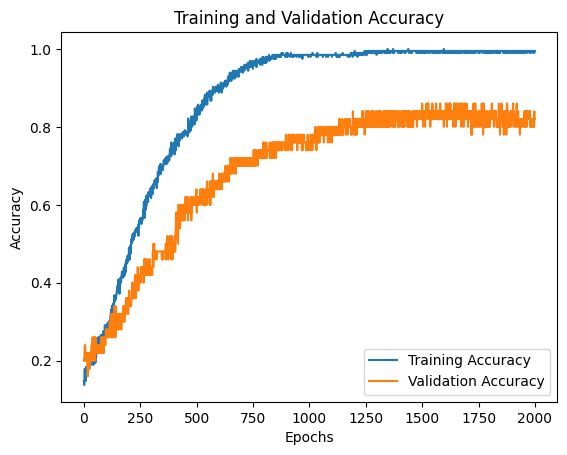

In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
import matplotlib.pyplot as plt

# Define your folder structure
data_dir = '/content/babycry/Data/Audio_augmentation'
classes = os.listdir(data_dir)

def load_and_preprocess_data(data_dir, classes, target_length=16000,size = 128):
    data = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            file_path = os.path.join(class_dir, filename)
            audio_data, _ = librosa.load(file_path, sr=None, duration=7.0)
            # Perform feature extraction
            mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=target_length)
            chroma = librosa.feature.chroma_stft(y=audio_data, sr=target_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=target_length)
            tonnetz = librosa.feature.tonnetz(y=audio_data, sr=target_length)

            # Resize features to the same shape
            mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), (size, size))
            chroma = resize(np.expand_dims(chroma, axis=-1), (size, size))
            spectral_contrast = resize(np.expand_dims(spectral_contrast, axis=-1), (size, size))
            tonnetz = resize(np.expand_dims(tonnetz, axis=-1), (size, size))

            # Concatenate all features
            features = np.concatenate([mel_spectrogram, chroma, spectral_contrast, tonnetz], axis=-1)

            data.append(features)
            labels.append(i)

    return np.array(data), np.array(labels)

# Split data into training and testing sets
data, labels = load_and_preprocess_data(data_dir, classes)
labels = to_categorical(labels, num_classes=len(classes))
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create a simplified neural network model
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(128, (3, 3), activation='relu')(input_layer)
x = Flatten()(x)
# x = Dense(64, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)
model = Model(input_layer, output_layer)

# Compile the model
optimizer = Adam(learning_rate=0.00000001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the simplified model
batch_size = 16
epochs = 2000

# Add callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=20, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_test, y_test))

# Evaluate the simplified model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

# Save the simplified model
model.save('audio_classification_simplified_model.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()